# Breast cancer case

In [18]:
import numpy as np
import pandas as pd
import feyn

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

from _crossvalidation import crossvalidation_as_framework

### Load and prep data

In [6]:
data = pd.read_csv('../data/brca_data_w_meta.csv')

In [7]:
# Define the target variable
target = "vital.status"

In [8]:
stypes = {}
for f in data.columns:
    if data[f].dtype == 'object':
        stypes[f] = 'c'

### 2 feature models

In [77]:
results = crossvalidation_as_framework(data,
                                     target,
                                     kind = "classification",
                                     stypes = stypes,
                                     n_epochs = 50,
                                     criterion='bic',
                                     max_complexity = 3)

In [78]:
results.groupby("fold").first().roc_auc_val.mean(), results.roc_auc_val.mean()

(0.6474232139502873, 0.6386899509202167)

In [125]:
results.groupby("fold").first()

,model_structure,aic,bic,roc_auc_train,accuracy_train,roc_auc_val,accuracy_val,pr_auc,f1
fold,,,,,,,,,
0,logreg(exp(-rsFOLR1**2 - rsTNMD**2)),649.050429,666.390646,0.646638,0.854610,0.688799,0.843972,0.312621,0.222222
1,logreg(exp(-rsAPOB**2 - rsPOF1B**2)),640.531253,657.871470,0.648507,0.870567,0.569456,0.836879,0.305527,0.235294
2,logreg(exp(-rsACVR1C**2 - rsFLJ45983**2)),626.550910,643.891127,0.642072,0.863475,0.494823,0.829787,0.235780,0.246575
3,logreg(exp(-rsKCNIP2**2 - rsOXTR**2)),644.160035,661.500252,0.612270,0.852837,0.757118,0.893617,0.501655,0.243590
4,logreg(rsAPOB*rsSLC13A2),663.004001,671.674110,0.672147,0.776596,0.726920,0.787234,0.494273,0.245161


In [79]:
for model in results.groupby("fold").first().model_structure:
    print(model)

logreg(exp(-rsFOLR1**2 - rsTNMD**2))
logreg(exp(-rsAPOB**2 - rsPOF1B**2))
logreg(exp(-rsACVR1C**2 - rsFLJ45983**2))
logreg(exp(-rsKCNIP2**2 - rsOXTR**2))
logreg(rsAPOB*rsSLC13A2)


#### Exploration of best models

In [6]:
ql = feyn.connect_qlattice()

In [7]:
best_models_qstrings = ['gaussian("rs_FOLR1", "rs_TNMD")',
                        'gaussian("rs_APOB", "rs_POF1B")',
                        'gaussian("rs_ACVR1C", "rs_FLJ45983")',
                        'gaussian("rs_KCNIP2", "rs_OXTR")',
                        '"rs_APOB"*"rs_SLC13A2"']
n_folds = 5
random_state = 42
models_trained = []
train_list = []
val_list = []

kfold_test = StratifiedKFold(n_folds, shuffle=True, random_state=random_state)
for i, (train, val) in enumerate(kfold_test.split(data, data[target])):
        train, val = data.iloc[train], data.iloc[val]
        train_list.append(train)
        val_list.append(val)
        
        sample_weights = np.where(train[target] == 1,
                                      np.sum(train[target] == 0) / sum(train[target]), 1)
        
        ql.reset(random_state)
        model = ql.auto_run(train, output_name=target, n_epochs=20, kind = "classification",
                             query_string=best_models_qstrings[i], sample_weights=sample_weights, stypes=stypes)[0]
        models_trained.append(model)

<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="216.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 621 216.0" width="621" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="155.0" width="351" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="241" y="50.0"><title>vital.status
logistic:
w=1.7231
bias=-0.3497</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="71.5">vital.st..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="59.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="243" y="59.0">out</text><line stroke="#1E1E1E" x1="211" x2="241" y1="67.5" y2="67.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="50.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="71.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="59.0">1</text><line stroke="#1E1E1E" x1="91" x2="121" y1="37.5" y2="58.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="97.5" y2="76.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="20.0"><title>rs_APOB
linear:
scale=0.149502
scale offset=2.288630
w=1.384997
bias=0.3326</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="41.5">rs_APOB</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="29.0">2</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="29.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="80.0"><title>rs_SLC13A2
linear:
scale=0.165339
scale offset=4.554204
w=1.058438
bias=0.2992</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="101.5">rs_SLC13A2</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="89.0">3</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="89.0">num</text></svg><svg class="summary" height="79" width="180" x="351" y="0"><defs /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="0" y="14">Training Metrics</text><line stroke="#1E1E1E" x1="0" x2="160" y1="19" y2="19" /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="34">Accuracy</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="34">0.755</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="49">AUC</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="49">0.675</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="64">Precision</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="64">0.263</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start" x="5" y="79">Recall</text><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="end" x="155" y="79">0.467</text></svg><svg class="summary" height="79" width="90" x="531" y="0"><defs /><text fill="#1E1E1E" font-family="monospace" font-size="14" text-anchor="start
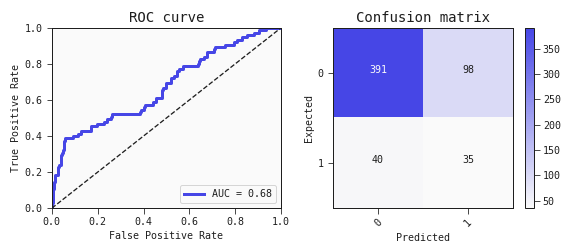
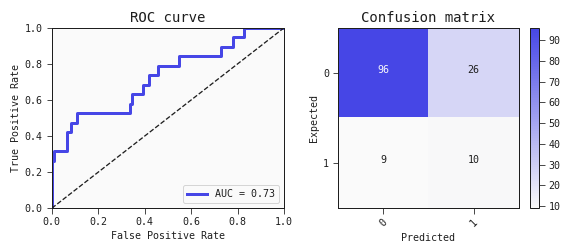

In [8]:
models_trained[-1].plot(train_list[-1], val_list[-1])

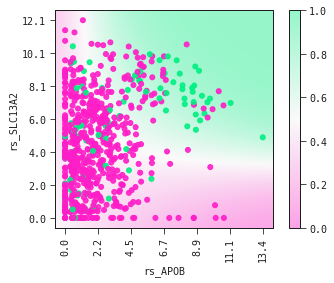

In [9]:
models_trained[-1].plot_response_2d(data)

### Larger models

In [116]:
results7 = crossvalidation_as_framework(data,
                                     target,
                                     kind = "classification",
                                     stypes = stypes,
                                     n_epochs = 100,
                                     max_complexity=7,
                                     criterion='bic')

In [117]:
results7.groupby("fold").first().roc_auc_val.mean(), results7.roc_auc_val.mean()

(0.6216999360100014, 0.6351688564340345)

In [124]:
results7.groupby("fold").first()

,model_structure,aic,bic,roc_auc_train,accuracy_train,roc_auc_val,accuracy_val,pr_auc,f1
fold,,,,,,,,,
0,logreg(rsFGFBP1 + rsPIK3C2G*(muITPR2 + rsACVR1C)),624.149066,641.489283,0.774374,0.730496,0.581752,0.695035,0.358006,0.216561
1,logreg(rsAPOB*(cnPRODH + rsC1orf173 + rsHEPACA...,590.162173,607.502390,0.772434,0.776596,0.573339,0.716312,0.203100,0.230769
2,logreg(cnABCC6 + rsSLC7A10*(rsSLC28A3 + rsWNK4)),607.773098,625.113315,0.768616,0.771277,0.600086,0.716312,0.278397,0.240506
3,logreg(rsLOC283392*rsSHISA2*(cnPCSK9 + rsKLK7)),594.728361,616.403632,0.766844,0.774823,0.635030,0.780142,0.248254,0.230769
4,logreg(rsHEPACAM2*(cnFABP7 + rsASCL1 + rsGLYAT)),636.678608,654.018825,0.733306,0.785461,0.718292,0.744681,0.377650,0.248276


In [118]:
for model in results7.groupby("fold").first().model_structure:
    print(model)

logreg(rsFGFBP1 + rsPIK3C2G*(muITPR2 + rsACVR1C))
logreg(rsAPOB*(cnPRODH + rsC1orf173 + rsHEPACAM2))
logreg(cnABCC6 + rsSLC7A10*(rsSLC28A3 + rsWNK4))
logreg(rsLOC283392*rsSHISA2*(cnPCSK9 + rsKLK7))
logreg(rsHEPACAM2*(cnFABP7 + rsASCL1 + rsGLYAT))


In [119]:
results10 = crossvalidation_as_framework(data,
                                     target,
                                     kind = "classification",
                                     stypes = stypes,
                                     n_epochs = 100,
                                     max_complexity=10,
                                     criterion='bic')

In [120]:
results10.groupby("fold").first().roc_auc_val.mean(), results10.roc_auc_val.mean()

(0.62131661955101, 0.6364887066615849)

In [122]:
results10.groupby("fold").first()

,model_structure,aic,bic,roc_auc_train,accuracy_train,roc_auc_val,accuracy_val,pr_auc,f1
fold,,,,,,,,,
0,logreg(rsPTCHD1*(cnADAMTS16 + muDMD + rsFABP4 ...,600.081058,621.756329,0.756606,0.806738,0.558266,0.758865,0.203278,0.220779
1,logreg(rsAPOB*(cnPRODH*(cnCOL14A1 + ppPI3K.p11...,583.045850,609.056175,0.784349,0.801418,0.630285,0.702128,0.219180,0.243590
2,logreg(cnCLCA2 + rsSLC13A2*(cnSLC30A8 + rsAPOB...,599.551998,621.227269,0.761609,0.808511,0.716135,0.815603,0.340016,0.245161
3,logreg(rsTCN1*(ppp27 + rsDEFB132*rsPTPRZ1 + rs...,622.038025,648.048350,0.778350,0.735816,0.577653,0.602837,0.379337,0.248366
4,logreg(cnTNFRSF11B + ppMSH6**2 + rsCYP4Z2P + r...,625.441638,647.116909,0.780177,0.721631,0.624245,0.638298,0.327341,0.235294


In [121]:
for model in results10.groupby("fold").first().model_structure:
    print(model)

logreg(rsPTCHD1*(cnADAMTS16 + muDMD + rsFABP4 + rsSOX2))
logreg(rsAPOB*(cnPRODH*(cnCOL14A1 + ppPI3K.p110.alpha) + rsTAT))
logreg(cnCLCA2 + rsSLC13A2*(cnSLC30A8 + rsAPOB + rsPAX7))
logreg(rsTCN1*(ppp27 + rsDEFB132*rsPTPRZ1 + rsSOX2))
logreg(cnTNFRSF11B + ppMSH6**2 + rsCYP4Z2P + rsPCOLCE2 + rsPLA2G2D)


### Comparison with random forest

In [9]:
df = pd.get_dummies(data)


parameters={'bootstrap': [True, False],
             'ccp_alpha': [0.0],
             'class_weight': ['balanced'],
             'max_depth': [3, 4, 5],
             'max_features': ['auto', 'sqrt'],
             'max_leaf_nodes': [None],
             'max_samples': [None],
             'min_impurity_decrease': [0.0],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [5, 10, 15],
             'min_weight_fraction_leaf': [0.0],
             'n_estimators': [50, 75, 100],
             'random_state': [42]
                }

rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, verbose=1, n_jobs=-1, scoring='roc_auc')
clf.fit(df.drop(columns=target), df[target])

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'ccp_alpha': [0.0],
                         'class_weight': ['balanced'], 'max_depth': [3, 4, 5],
                         'max_features': ['auto', 'sqrt'],
                         'max_leaf_nodes': [None], 'max_samples': [None],
                         'min_impurity_decrease': [0.0],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [5, 10, 15],
                         'min_weight_fraction_leaf': [0.0],
                         'n_estimators': [50, 75, 100], 'random_state': [42]},
             scoring='roc_auc', verbose=1)

In [11]:
clf.best_params_

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'max_depth': 4,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'random_state': 42}

In [12]:
# a bit overestimated score due to hp-tuning and model selection
clf.best_score_

0.6587626937529081

In [35]:
# Nested cross-validation scheme to estimate performance

list_auc = []
n_folds = 5
random_state = 42
df = pd.get_dummies(data)

kfold_test = StratifiedKFold(n_folds, shuffle=True, random_state=random_state)

for i, (train, val) in enumerate(kfold_test.split(df, df[target])):
    train_eval, val = df.iloc[train], df.iloc[val]
    train, eval_set = train_test_split(train_eval, train_size=.2, random_state=42, stratify=train_eval[target])
    sample_weights = np.where(train_eval[target] == 1, np.sum(train_eval[target] == 0) / sum(train_eval[target]), 1)
    
    rf = RandomForestClassifier()
    clf = GridSearchCV(rf, parameters, verbose=1, n_jobs=-1, scoring='roc_auc')
    clf.fit(train.drop(columns=target), train[target])
    
    preds = clf.predict_proba(val.drop(columns=target))[:,1]
    
    list_auc.append(roc_auc_score(val[target], preds))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


In [36]:
list_auc

[0.552393857271906,
 0.7791199309749784,
 0.47001725625539253,
 0.6736410698878342,
 0.6540120793787748]

In [37]:
np.mean(list_auc)

0.6258368387537773

### Story

- Two feature model
     - performance
     - plot_response_2d
     - 5 models, different features, correlations?
- Comparison with random forest
- Multiomics model
  - Comparison with 2 feature models